In [1]:
from SimPEG import *
import simpegDCIP as DC
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


# Step1 Generate mesh 

In [3]:
cs = 25.
hx = [(cs,7, -1.3),(cs,21),(cs,7, 1.3)]
hy = [(cs,7, -1.3),(cs,21),(cs,7, 1.3)]
hz = [(cs,7, -1.3),(cs,20)]

In [4]:
mesh = Mesh.TensorMesh([hx, hy, hz], 'CCN')

In [10]:
blk1 = Utils.ModelBuilder.getIndicesBlock(np.r_[-50, 75, -50], np.r_[75, -50, -150], mesh.gridCC)
sighalf = 1e-3
sigma = np.ones(mesh.nC)*sighalf
sigma[blk1] = 1e-1
sigmahomo = np.ones(mesh.nC)*sighalf

(<matplotlib.collections.QuadMesh at 0x1077c3550>,
 <matplotlib.lines.Line2D at 0x1077c39d0>)

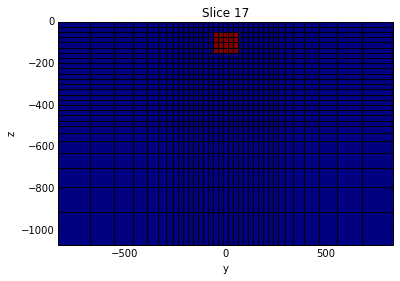

In [11]:
mesh.plotSlice(sigma, normal='X', grid=True)

In [18]:
xtemp = np.linspace(-150, 150, 21)
ytemp = np.linspace(-150, 150, 21)
xyz_rxM = Utils.ndgrid(xtemp-10., ytemp, np.r_[0.])
xyz_rxN = Utils.ndgrid(xtemp+10., ytemp, np.r_[0.])
# xyz_rxM = Utils.ndgrid(xtemp, ytemp, np.r_[0.])

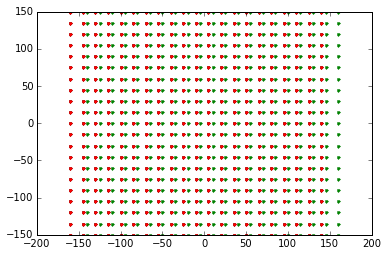

In [19]:
plt.plot(xyz_rxP[:,0], xyz_rxP[:,1], 'k.')
plt.plot(xyz_rxM[:,0], xyz_rxM[:,1], 'r.')
plt.plot(xyz_rxN[:,0], xyz_rxN[:,1], 'g.')

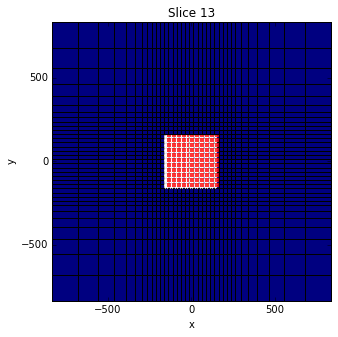

In [20]:
fig, ax = plt.subplots(1,1, figsize = (5,5))
mesh.plotSlice(sigma, grid=True, ax = ax)
ax.plot(xyz_rxP[:,0],xyz_rxP[:,1], 'w.')
ax.plot(xyz_rxN[:,0],xyz_rxN[:,1], 'r.', ms = 3)

In [22]:
rx

In [23]:
rx = DC.RxDipole(xyz_rxM, xyz_rxN)
tx = DC.SrcDipole([rx], [-200, 0, -12.5],[+200, 0, -12.5])

In [24]:
txList = []
txList.append(DC.SrcDipole([rx], [-200, 0, -12.5],[+200, 0, -12.5]))
txList.append(DC.SrcDipole([rx], [-200, 0, -12.5],[+100, 0, -12.5]))

In [25]:
txList

In [26]:
# survey = DC.SurveyDC([tx])
survey = DC.SurveyDC(txList)

In [30]:
# survey.unpair()
problem = DC.ProblemDC_CC(mesh)
problem.pair(survey)

In [31]:
try:
    from pymatsolver import MumpsSolver
    problem.Solver = MumpsSolver
except Exception, e:
    problem.Solver = SolverLU

In [43]:
%%time
dataP = survey.dpred(sigmahomo)

CPU times: user 1.25 s, sys: 177 ms, total: 1.42 s
Wall time: 970 ms


In [44]:
data = survey.dpred(sigma)

In [45]:
Data = (data/dataP).reshape((21,21,2), order='F')

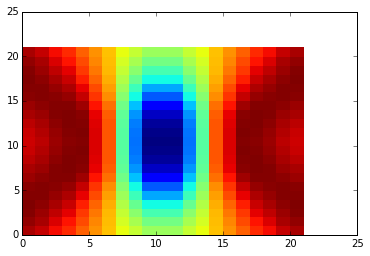

In [46]:
plt.pcolor(Data[:,:,0].T)

In [17]:
u1 = problem.fields(sigma)
u2 = problem.fields(sigmahomo)

In [34]:
# Msig1 = Utils.sdiag(1./(mesh.aveF2CC.T*(1./sigma)))
# Msig2 = Utils.sdiag(1./(mesh.aveF2CC.T*(1./sigmahomo)))

In [19]:
j1 = Msig1*mesh.cellGrad*u1[tx, 'phi_sol']
j2 = Msig2*mesh.cellGrad*u2[tx, 'phi_sol']

In [21]:
# us = u1-u2
# js = j1-j2

(-300, 0)

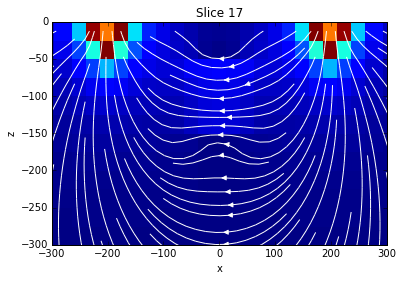

In [22]:
mesh.plotSlice(mesh.aveF2CCV*j1, vType='CCv', normal='Y', view='vec', streamOpts={"density":3, "color":'w'})
xlim(-300, 300)
ylim(-300, 0)

In [23]:
mesh.plotSlice(mesh.aveF2CCV*js, vType='CCv', normal='Y', view='vec', streamOpts={"density":3, "color":'w'})
xlim(-300, 300)
ylim(-300, 0)

NameError: name 'js' is not defined

In [ ]:
a = np.random.randn(3)

In [ ]:
print (a.reshape([1,-1])).repeat(3, axis = 0)
print (a.reshape([1,-1])).repeat(3, axis = 0).sum(axis=1)

In [ ]:
def DChalf(txlocP, txlocN, rxloc, sigma, I=1.):
    rp = (txlocP.reshape([1,-1])).repeat(rxloc.shape[0], axis = 0)
    rn = (txlocN.reshape([1,-1])).repeat(rxloc.shape[0], axis = 0)
    rP = np.sqrt(((rxloc-rp)**2).sum(axis=1))
    rN = np.sqrt(((rxloc-rn)**2).sum(axis=1))
    return I/(sigma*2.*np.pi)*(1/rP-1/rN)

In [ ]:
data_analP = DChalf(np.r_[-200, 0, 0.],np.r_[+200, 0, 0.], xyz_rxP, sighalf)
data_analN = DChalf(np.r_[-200, 0, 0.],np.r_[+200, 0, 0.], xyz_rxN, sighalf)
data_anal = data_analP-data_analN

In [ ]:
Data_anal = data_anal.reshape((21, 21), order = 'F')
Data = data.reshape((21, 21), order = 'F')
X = xyz_rxM[:,0].reshape((21, 21), order = 'F')
Y = xyz_rxM[:,1].reshape((21, 21), order = 'F')

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (12, 5))
vmin = np.r_[data, data_anal].min()
vmax = np.r_[data, data_anal].max()
dat0 = ax[0].contourf(X, Y, Data, 60, vmin = vmin, vmax = vmax)
dat1 = ax[1].contourf(X, Y, Data_anal, 60, vmin = vmin, vmax = vmax)
cb0 = plt.colorbar(dat1, orientation = 'horizontal', ax = ax[0])
cb1 = plt.colorbar(dat1, orientation = 'horizontal', ax = ax[1])